*Load data*


In [1]:
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

--2022-12-10 05:47:38--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 172.217.194.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  21.4MB/s    in 7.5s    

2022-12-10 05:47:47 (18.9 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



In [2]:
import os 
import zipfile
import tensorflow as tf

In [3]:
local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')


*Use ImageGenerator to label and prepare data*

In [4]:
#Répertoire avec nos photos de chevaux pour l'entraînement 
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')
#Répertoire avec nos photos des humain pour l'entraînement 
train_human_dir = os.path.join('/tmp/horse-or-human/humans')


In [5]:
train_horse_names = os.listdir(train_horse_dir) 
print(train_horse_names[:10])
train_human_names = os.listdir(train_human_dir) 
print(train_human_names[:10])

['horse26-8.png', 'horse43-2.png', 'horse46-0.png', 'horse16-0.png', 'horse02-2.png', 'horse07-8.png', 'horse38-2.png', 'horse27-7.png', 'horse48-8.png', 'horse04-1.png']
['human07-30.png', 'human11-27.png', 'human02-20.png', 'human15-27.png', 'human11-21.png', 'human16-05.png', 'human16-18.png', 'human13-20.png', 'human17-09.png', 'human01-21.png']


In [6]:
print('total training horse images:', len(os.listdir(train_horse_dir))) 
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


*Visualization of data*

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
# Parameters for our graph; we'll output images in a 4x4 configuration 
nrows = 4
ncols = 4
# Index for iterating over images 
pic_index = 0

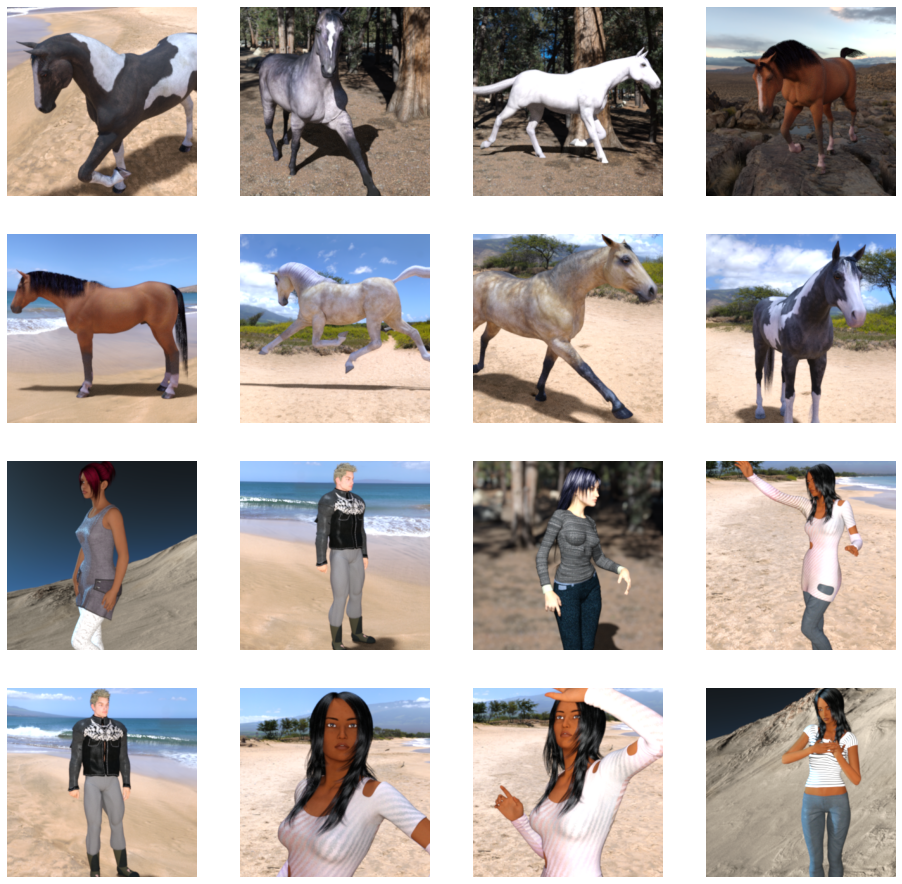

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics 
fig = plt.gcf()
fig.set_size_inches(nrows*4, ncols*4) 
pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname)
                 for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname)
                 for fname in train_human_names[pic_index-8:pic_index]]
for i, img_path in enumerate(next_horse_pix+next_human_pix): 
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('off') # Don't show axes (or gridlines) 
    img = mpimg.imread(img_path)
    plt.imshow(img) 
plt.show()

*Define the model*

In [26]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color this is the first convolution
    tf.keras.layers.Conv2D(16,(3,3), activation = 'relu',input_shape = (300,300,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    #Ajouter le 2éme couche de convolution
    tf.keras.layers.Conv2D(32,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #Ajouter le 3éme couche de convolution
    tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #Ajouter le 4éme couche de convolution
    tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #Ajouter le 5éme couche de convolution
    tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #étaller les données en un seul vecteur
    tf.keras.layers.Flatten(),
    #Les couches fully connected
    tf.keras.layers.Dense(512,activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')

])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

*Compile the model*

In [27]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer = RMSprop(learning_rate=0.001),
              loss = 'binary_crossentropy',
              metrics =['accuracy'])

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
# Flow training images in batches of 128 using train_datagen generator 
train_generator = train_datagen.flow_from_directory(
   '/tmp/horse-or-human/',  # This is the source directory for training images 
   target_size=(300, 300),  # All images will be resized to 300x300
   batch_size=128,
   # Since we use binary_crossentropy loss, we need binary labels 
   class_mode='binary')

Found 1027 images belonging to 2 classes.


*Train the model*

In [29]:
history = model.fit( 
    train_generator, 
    steps_per_epoch=8, 
    epochs=15,
    verbose=1)

Epoch 1/15
8/8 [==============================] - 7s 692ms/step - loss: 0.8096 - accuracy: 0.5462
Epoch 2/15
8/8 [==============================] - 6s 686ms/step - loss: 0.6619 - accuracy: 0.7041
Epoch 3/15
8/8 [==============================] - 6s 711ms/step - loss: 0.6856 - accuracy: 0.7831
Epoch 4/15
8/8 [==============================] - 7s 895ms/step - loss: 0.3615 - accuracy: 0.8687
Epoch 5/15
8/8 [==============================] - 6s 715ms/step - loss: 0.2144 - accuracy: 0.9121
Epoch 6/15
8/8 [==============================] - 6s 715ms/step - loss: 0.1544 - accuracy: 0.9511
Epoch 7/15
8/8 [==============================] - 6s 704ms/step - loss: 0.1530 - accuracy: 0.9444
Epoch 8/15
8/8 [==============================] - 6s 685ms/step - loss: 0.1262 - accuracy: 0.9533
Epoch 9/15
8/8 [==============================] - 7s 806ms/step - loss: 0.3477 - accuracy: 0.8965
Epoch 10/15
8/8 [==============================] - 6s 705ms/step - loss: 0.0769 - accuracy: 0.9822
Epoch 11/15
8/8 [==

*Test the model*

In [30]:
import numpy as np
from google.colab import files
from keras.utils import load_img, img_to_array 
uploaded = files.upload()
for fn in uploaded.keys():
  # predicting images 
  path = '/content/' + fn
  img = load_img(path, target_size=(300, 300)) 
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0) 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10) 
  print(classes[0])
  if classes[0]>0.5:
     print(fn + " is a human") 
  else:
     print(fn + " is a horse")

Saving horse.jpg to horse (3).jpg
Saving horse1.jpeg to horse1 (3).jpeg
Saving human.webp to human (3).webp
Saving human1.jpg to human1 (3).jpg
Saving human2.webp to human2 (3).webp
1/1 [==============================] - 0s 80ms/step
[0.]
horse.jpg is a horse
1/1 [==============================] - 0s 15ms/step
[0.]
horse1.jpeg is a horse
1/1 [==============================] - 0s 17ms/step
[0.]
human.webp is a horse
1/1 [==============================] - 0s 18ms/step
[1.]
human1.jpg is a human
1/1 [==============================] - 0s 16ms/step
[0.]
human2.webp is a horse


The problem we have in this state is overfitting.



# Batch Normalization

In [31]:
from tensorflow.keras.layers import BatchNormalization

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color this is the first convolution
    tf.keras.layers.Conv2D(16,(3,3), activation = 'relu',input_shape = (300,300,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    #Ajouter le 2éme couche de convolution
    tf.keras.layers.Conv2D(32,(3,3), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    #Ajouter le 3éme couche de convolution
    tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
   tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    #Ajouter le 4éme couche de convolution
    tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    #Ajouter le 5éme couche de convolution
    tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    #étaller les données en un seul vecteur
    tf.keras.layers.Flatten(),
    #Les couches fully connected
    tf.keras.layers.Dense(512,activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')

])

In [32]:
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 298, 298, 16)      448       
                                                                 
 batch_normalization_10 (Bat  (None, 298, 298, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 149, 149, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 147, 147, 32)      4640      
                                                                 
 batch_normalization_11 (Bat  (None, 147, 147, 32)     128       
 chNormalization)                                                
                                                      

In [33]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer = RMSprop(learning_rate=0.001),
              loss = 'binary_crossentropy',
              metrics =['accuracy'])

In [34]:
history = model.fit( 
    train_generator, 
    steps_per_epoch=8, 
    epochs=15,
    verbose=1)

Epoch 1/15
8/8 [==============================] - 8s 806ms/step - loss: 1.1030 - accuracy: 0.8242
Epoch 2/15
8/8 [==============================] - 6s 733ms/step - loss: 0.2670 - accuracy: 0.9422
Epoch 3/15
8/8 [==============================] - 6s 730ms/step - loss: 0.0156 - accuracy: 0.9978
Epoch 4/15
8/8 [==============================] - 6s 745ms/step - loss: 6.6576e-04 - accuracy: 1.0000
Epoch 5/15
8/8 [==============================] - 6s 731ms/step - loss: 3.7044e-04 - accuracy: 1.0000
Epoch 6/15
8/8 [==============================] - 6s 900ms/step - loss: 2.7596e-04 - accuracy: 1.0000
Epoch 7/15
8/8 [==============================] - 6s 733ms/step - loss: 1.4008e-04 - accuracy: 1.0000
Epoch 8/15
8/8 [==============================] - 6s 731ms/step - loss: 1.1998e-04 - accuracy: 1.0000
Epoch 9/15
8/8 [==============================] - 6s 726ms/step - loss: 6.8975e-05 - accuracy: 1.0000
Epoch 10/15
8/8 [==============================] - 6s 735ms/step - loss: 4.4712e-05 - accuracy

In [35]:
import numpy as np
from google.colab import files
from keras.utils import load_img, img_to_array 
uploaded = files.upload()
for fn in uploaded.keys():
  # predicting images 
  path = '/content/' + fn
  img = load_img(path, target_size=(300, 300)) 
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0) 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10) 
  print(classes[0])
  if classes[0]>0.5:
     print(fn + " is a human") 
  else:
     print(fn + " is a horse")

Saving horse.jpg to horse (4).jpg
Saving horse1.jpeg to horse1 (4).jpeg
Saving human.webp to human (4).webp
Saving human1.jpg to human1 (4).jpg
Saving human2.webp to human2 (4).webp
1/1 [==============================] - 0s 123ms/step
[7.6473464e-23]
horse.jpg is a horse
1/1 [==============================] - 0s 16ms/step
[1.]
horse1.jpeg is a human
1/1 [==============================] - 0s 15ms/step
[1.]
human.webp is a human
1/1 [==============================] - 0s 16ms/step
[1.]
human1.jpg is a human
1/1 [==============================] - 0s 15ms/step
[1.]
human2.webp is a human


#  Dropout

In [36]:
from tensorflow.keras.layers import Dropout

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color this is the first convolution
    tf.keras.layers.Conv2D(16,(3,3), activation = 'relu',input_shape = (300,300,3)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2,2),
    #Ajouter le 2éme couche de convolution
    tf.keras.layers.Conv2D(32,(3,3), activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2,2),
    #Ajouter le 3éme couche de convolution
    tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2,2),
    #Ajouter le 4éme couche de convolution
    tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2,2),
    #Ajouter le 5éme couche de convolution
    tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2,2),
    #étaller les données en un seul vecteur
    tf.keras.layers.Flatten(),
    #Les couches fully connected
    tf.keras.layers.Dense(512,activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')

])

In [37]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 298, 298, 16)      448       
                                                                 
 dropout (Dropout)           (None, 298, 298, 16)      0         
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 149, 149, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 147, 147, 32)      4640      
                                                                 
 dropout_1 (Dropout)         (None, 147, 147, 32)      0         
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 73, 73, 32)       0         
 g2D)                                                 

In [38]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer = RMSprop(learning_rate=0.001),
              loss = 'binary_crossentropy',
              metrics =['accuracy'])

In [39]:
history = model.fit( 
    train_generator, 
    steps_per_epoch=8, 
    epochs=15,
    verbose=1)

Epoch 1/15
8/8 [==============================] - 7s 740ms/step - loss: 1.2519 - accuracy: 0.5006
Epoch 2/15
8/8 [==============================] - 6s 728ms/step - loss: 0.7286 - accuracy: 0.7330
Epoch 3/15
8/8 [==============================] - 6s 740ms/step - loss: 0.4627 - accuracy: 0.7842
Epoch 4/15
8/8 [==============================] - 6s 742ms/step - loss: 0.5618 - accuracy: 0.8398
Epoch 5/15
8/8 [==============================] - 6s 726ms/step - loss: 0.3370 - accuracy: 0.8598
Epoch 6/15
8/8 [==============================] - 7s 824ms/step - loss: 0.1473 - accuracy: 0.9443
Epoch 7/15
8/8 [==============================] - 6s 737ms/step - loss: 0.1501 - accuracy: 0.9410
Epoch 8/15
8/8 [==============================] - 6s 746ms/step - loss: 0.3493 - accuracy: 0.8654
Epoch 9/15
8/8 [==============================] - 6s 739ms/step - loss: 0.2144 - accuracy: 0.9344
Epoch 10/15
8/8 [==============================] - 7s 804ms/step - loss: 0.0337 - accuracy: 0.9944
Epoch 11/15
8/8 [==

In [40]:
import numpy as np
from google.colab import files
from keras.utils import load_img, img_to_array 
uploaded = files.upload()
for fn in uploaded.keys():
  # predicting images 
  path = '/content/' + fn
  img = load_img(path, target_size=(300, 300)) 
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0) 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10) 
  print(classes[0])
  if classes[0]>0.5:
     print(fn + " is a human") 
  else:
     print(fn + " is a horse")

Saving horse.jpg to horse (5).jpg
Saving horse1.jpeg to horse1 (5).jpeg
Saving human.webp to human (5).webp
Saving human1.jpg to human1 (5).jpg
Saving human2.webp to human2 (5).webp
1/1 [==============================] - 0s 79ms/step
[0.]
horse.jpg is a horse
1/1 [==============================] - 0s 18ms/step
[0.]
horse1.jpeg is a horse
1/1 [==============================] - 0s 16ms/step
[0.]
human.webp is a horse
1/1 [==============================] - 0s 14ms/step
[1.]
human1.jpg is a human
1/1 [==============================] - 0s 15ms/step
[0.]
human2.webp is a horse


# Changing Optimizer function 

In [41]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color this is the first convolution
    tf.keras.layers.Conv2D(16,(3,3), activation = 'relu',input_shape = (300,300,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    #Ajouter le 2éme couche de convolution
    tf.keras.layers.Conv2D(32,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #Ajouter le 3éme couche de convolution
    tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #Ajouter le 4éme couche de convolution
    tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #Ajouter le 5éme couche de convolution
    tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #étaller les données en un seul vecteur
    tf.keras.layers.Flatten(),
    #Les couches fully connected
    tf.keras.layers.Dense(512,activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')

])

In [42]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 149, 149, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 73, 73, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 35, 35, 64)      

In [43]:
from tensorflow.keras.optimizers import Adagrad

model.compile(optimizer = Adagrad(learning_rate=0.001),
              loss = 'binary_crossentropy',
              metrics =['accuracy'])

In [44]:
history = model.fit( 
    train_generator, 
    steps_per_epoch=8, 
    epochs=15,
    verbose=1)

Epoch 1/15
8/8 [==============================] - 7s 712ms/step - loss: 0.6929 - accuracy: 0.4950
Epoch 2/15
8/8 [==============================] - 6s 719ms/step - loss: 0.6922 - accuracy: 0.4961
Epoch 3/15
8/8 [==============================] - 6s 698ms/step - loss: 0.6919 - accuracy: 0.5339
Epoch 4/15
8/8 [==============================] - 6s 835ms/step - loss: 0.6913 - accuracy: 0.5773
Epoch 5/15
8/8 [==============================] - 7s 791ms/step - loss: 0.6907 - accuracy: 0.6104
Epoch 6/15
8/8 [==============================] - 6s 707ms/step - loss: 0.6901 - accuracy: 0.6841
Epoch 7/15
8/8 [==============================] - 6s 688ms/step - loss: 0.6896 - accuracy: 0.6930
Epoch 8/15
8/8 [==============================] - 6s 717ms/step - loss: 0.6890 - accuracy: 0.6485
Epoch 9/15
8/8 [==============================] - 6s 697ms/step - loss: 0.6884 - accuracy: 0.6819
Epoch 10/15
8/8 [==============================] - 6s 714ms/step - loss: 0.6874 - accuracy: 0.5384
Epoch 11/15
8/8 [==

In [45]:
import numpy as np
from google.colab import files
from keras.utils import load_img, img_to_array 
uploaded = files.upload()
for fn in uploaded.keys():
  # predicting images 
  path = '/content/' + fn
  img = load_img(path, target_size=(300, 300)) 
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0) 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10) 
  print(classes[0])
  if classes[0]>0.5:
     print(fn + " is a human") 
  else:
     print(fn + " is a horse")

Saving horse.jpg to horse (6).jpg
Saving horse1.jpeg to horse1 (6).jpeg
Saving human.webp to human (6).webp
Saving human1.jpg to human1 (6).jpg
Saving human2.webp to human2 (6).webp
1/1 [==============================] - 0s 74ms/step
[0.99999917]
horse.jpg is a human
1/1 [==============================] - 0s 19ms/step
[0.9999988]
horse1.jpeg is a human
1/1 [==============================] - 0s 18ms/step
[0.9947864]
human.webp is a human
1/1 [==============================] - 0s 16ms/step
[0.9999951]
human1.jpg is a human
1/1 [==============================] - 0s 18ms/step
[1.]
human2.webp is a human


# Changing Loss Function 

In [46]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color this is the first convolution
    tf.keras.layers.Conv2D(16,(3,3), activation = 'relu',input_shape = (300,300,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    #Ajouter le 2éme couche de convolution
    tf.keras.layers.Conv2D(32,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #Ajouter le 3éme couche de convolution
    tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #Ajouter le 4éme couche de convolution
    tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #Ajouter le 5éme couche de convolution
    tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #étaller les données en un seul vecteur
    tf.keras.layers.Flatten(),
    #Les couches fully connected
    tf.keras.layers.Dense(512,activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')

])

In [47]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 149, 149, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 73, 73, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 35, 35, 64)      

In [48]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer = RMSprop(learning_rate=0.001),
              loss = 'binary_focal_crossentropy',
              metrics =['accuracy'])

In [49]:
history = model.fit( 
    train_generator, 
    steps_per_epoch=8, 
    epochs=15,
    verbose=1)

Epoch 1/15
8/8 [==============================] - 7s 847ms/step - loss: 0.3157 - accuracy: 0.5573
Epoch 2/15
8/8 [==============================] - 7s 806ms/step - loss: 0.1716 - accuracy: 0.6592
Epoch 3/15
8/8 [==============================] - 6s 831ms/step - loss: 0.1989 - accuracy: 0.7519
Epoch 4/15
8/8 [==============================] - 6s 705ms/step - loss: 0.2821 - accuracy: 0.7709
Epoch 5/15
8/8 [==============================] - 6s 719ms/step - loss: 0.0741 - accuracy: 0.9110
Epoch 6/15
8/8 [==============================] - 7s 920ms/step - loss: 0.0491 - accuracy: 0.9255
Epoch 7/15
8/8 [==============================] - 6s 708ms/step - loss: 0.0264 - accuracy: 0.9622
Epoch 8/15
8/8 [==============================] - 6s 706ms/step - loss: 0.2364 - accuracy: 0.8198
Epoch 9/15
8/8 [==============================] - 6s 833ms/step - loss: 0.0540 - accuracy: 0.9288
Epoch 10/15
8/8 [==============================] - 6s 714ms/step - loss: 0.0308 - accuracy: 0.9588
Epoch 11/15
8/8 [==

In [50]:
import numpy as np
from google.colab import files
from keras.utils import load_img, img_to_array 
uploaded = files.upload()
for fn in uploaded.keys():
  # predicting images 
  path = '/content/' + fn
  img = load_img(path, target_size=(300, 300)) 
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0) 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10) 
  print(classes[0])
  if classes[0]>0.5:
     print(fn + " is a human") 
  else:
     print(fn + " is a horse")

Saving horse.jpg to horse (7).jpg
Saving horse1.jpeg to horse1 (7).jpeg
Saving human.webp to human (7).webp
Saving human1.jpg to human1 (7).jpg
Saving human2.webp to human2 (7).webp
1/1 [==============================] - 0s 76ms/step
[0.]
horse.jpg is a horse
1/1 [==============================] - 0s 18ms/step
[0.]
horse1.jpeg is a horse
1/1 [==============================] - 0s 70ms/step
[0.]
human.webp is a horse
1/1 [==============================] - 0s 16ms/step
[1.]
human1.jpg is a human
1/1 [==============================] - 0s 16ms/step
[0.]
human2.webp is a horse
